<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Quickstart: Web Cam Action Recognition

Action recognition is the increasingly popular computer vision task of determining specific actions in a given video.

This notebook shows a simple example of loading a pretrained R(2+1)D model for action recognition and using a webcam stream to identify what actions are being performed.

For more details about the underlying technology of action recognition, including finetuning, please see our [training introduction notebook](01_training_introduction.ipynb).

## Prerequisite for Webcam example 
This notebook assumes you have **a webcam** connected to your machine.  We use the `ipywebrtc` module to show the webcam widget in the notebook. Currently, the widget works on **Chrome** and **Firefox**. For more details about the widget, please visit `ipywebrtc` [github](https://github.com/maartenbreddels/ipywebrtc) or [documentation](https://ipywebrtc.readthedocs.io/en/latest/).

## Initialization

In [1]:
# Regular Python libraries
import sys
from collections import deque #
import io
import requests
import os
from time import sleep, time
from threading import Thread
from IPython.display import Video

# Third party tools
import decord #
import IPython.display #
from ipywebrtc import CameraStream, ImageRecorder
from ipywidgets import HBox, HTML, Layout, VBox, Widget, Label
import numpy as np
from PIL import Image
import torch
import torch.cuda as cuda
import torch.nn as nn
from torchvision.transforms import Compose

# utils_cv
sys.path.append("../../")
from utils_cv.action_recognition.data import KINETICS, Urls
from utils_cv.action_recognition.dataset import get_transforms
from utils_cv.action_recognition.model import VideoLearner
from utils_cv.action_recognition.references import transforms_video as transforms
from utils_cv.common.gpu import system_info, torch_device
from utils_cv.common.data import data_path

system_info()

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0] 

PyTorch 1.2.0 

Torch-vision 0.4.0a0 

Available devices:
0: Tesla K80


In [2]:
%reload_ext autoreload
%autoreload 2

## Load Pre-trained Model

Load R(2+1)D 34-layer model pre-trained on IG65M or Kinetics400. There are also two versions of the model that we provide by default: an 8-frame model and 32-frame model based on the input clip length. As you'd expect, the 32-frame model is slower than 8-frame model. 

We'll start by setting some of these parameters.

In [3]:
NUM_FRAMES = 8  # 8 or 32.
IM_SCALE = 128  # resize then crop
INPUT_SIZE = 112  # input clip size: 3 x NUM_FRAMES x 112 x 112

# video sample to download
sample_video_url = Urls.webcam_vid

# file path to save video sample
video_fpath = data_path() / "sample_video.mp4"

# prediction score threshold
SCORE_THRESHOLD = 0.01

# Averaging 5 latest clips to make video-level prediction (or smoothing)
AVERAGING_SIZE = 5  

Next, we just need to initialize our VideoLearner model and add the parameters we set above.

In [4]:
learner = VideoLearner(
    base_model="kinetics",
    sample_length=NUM_FRAMES,
)

Loading r2plus1d_34_8_kinetics model


Using cache found in /home/jiata/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


## Prepare class names and prediction variables
Since we use Kinetics400 model out of the box, we load its class names. The dataset consists of 400 human actions. For example, the first 10 labels are:

In [20]:
LABELS = KINETICS.class_names
LABELS[:10]

['abseiling',
 'air drumming',
 'answering questions',
 'applauding',
 'applying cream',
 'archery',
 'arm wrestling',
 'arranging flowers',
 'assembling computer',
 'auctioning']

Among them, we will use 50 classes that we are interested in (i.e. the actions make sense to demonstrate in front of the webcam) and ignore other classes by filtering out from the model outputs. This will help us reduce the noise during prediction.

In [6]:
TARGET_LABELS = [
    "assembling computer",
    "applying cream",
    "brushing teeth",
    "clapping",
    "cleaning floor",
    "cleaning windows",
    "drinking",
    "eating burger",
    "eating chips",
    "eating doughnuts",
    "eating hotdog",
    "eating ice cream",
    "fixing hair",
    "hammer throw",
    "high kick",
    "jogging",
    "laughing",
    "mopping floor",
    "moving furniture",
    "opening bottle",
    "plastering",
    "punching bag",
    "punching person (boxing)",
    "pushing cart",
    "reading book",
    "reading newspaper",
    "rock scissors paper",
    "running on treadmill",
    "shaking hands",
    "shaking head",
    "side kick",
    "slapping",
    "smoking",
    "sneezing",
    "spray painting",
    "spraying",
    "stretching arm",
    "stretching leg",
    "sweeping floor",
    "swinging legs",
    "texting",
    "throwing axe",
    "throwing ball",
    "unboxing",
    "unloading truck",
    "using computer",
    "using remote controller (not gaming)",
    "welding",
    "writing",
    "yawning",
]
len(TARGET_LABELS)

50

# Action Recognition

## From a video file:
Here, we show how to use the model on a video file. We utilize threading so that the inference does not block the video preview. 

For this example, we'll use the following video:

In [7]:
Video(sample_video_url)

Download the video to our data folder

In [8]:
r = requests.get(sample_video_url)
open(video_fpath, 'wb').write(r.content)

210892

Since we already have our `learner` setup, we'll pass the video to the `predict_video()` function to get the results.

Total frames = 702


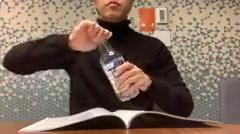

In [9]:
video = str(data_path()/"sample_video.mp4")
learner.predict_video(
    video,
    LABELS,
    averaging_size=AVERAGING_SIZE,
    score_threshold=SCORE_THRESHOLD,
    target_labels=TARGET_LABELS,
)

## From your webcam:

In this section we'll run the same model for prediction actions using our webcam. First we'll set up the webcam params.

In [10]:
# Webcam settings
w_cam = CameraStream(
    constraints={
        "facing_mode": "user",
        "audio": False,
        "video": {"width": 400, "height": 400},
    },
    layout=Layout(width="400px"),
)

# Image recorder for taking a snapshot
w_imrecorder = ImageRecorder(
    format="jpg", stream=w_cam, layout=Layout(padding="0 0 0 100px")
)

# Text widget to show our classification results
w_text = HTML(layout=Layout(padding="0 0 0 100px"))

Next, we'll create a function that uses the `learner`'s `predict_frames()` function so predict actions from the webcam. (This is the same function the `predict_video()` uses too!)

In [12]:
def predict_webcam_frames():
    """ Predict activity by using a pretrained model
    """
    global w_imrecorder, w_text, is_playing
    global device, model

    # Use deque for sliding window over frames
    window = deque()
    scores_cache = deque()
    scores_sum = np.zeros(len(LABELS))

    while is_playing:
        try:
            # Get the image (RGBA) and convert to RGB
            im = Image.open(io.BytesIO(w_imrecorder.image.value)).convert("RGB")
            window.append(np.array(im))

            # update println func
            def update_println(println):
                w_text.value = println
            
            if len(window) == NUM_FRAMES:
                learner.predict_frames(
                    window,
                    scores_cache,
                    scores_sum,
                    None,
                    AVERAGING_SIZE,
                    SCORE_THRESHOLD,
                    LABELS,
                    TARGET_LABELS,
                    get_transforms(train=False), 
                    update_println,
                )
            else:
                w_text.value = "Preparing..."
        except OSError:
            # If im_recorder doesn't have valid image data, skip it.
            pass
        except BaseException as e:
            w_text.value = "Exception: " + str(e)
            break

        # Taking the next snapshot programmatically
        w_imrecorder.recording = True
        sleep(0.02)

In [14]:
is_playing = False
#  Once prediciton started, hide image recorder widget for faster fps
def start(_):
    global is_playing
    # Make sure this get called only once
    if not is_playing:
        w_imrecorder.layout.display = "none"
        is_playing = True
        Thread(target=predict_webcam_frames).start()


w_imrecorder.image.observe(start, "value")

To start inference on webcam stream, click 'capture' button when the stream is started.

In [15]:
HBox([w_cam, w_imrecorder, w_text])

## Stop Webcam and clean-up

Stop the webcam by running the following code:

In [16]:
is_playing = False
Widget.close_all()

Learn more about fine-tuning action recognition models in our next [01_training_introduction.ipynb](01_training_introduction.ipynb) notebook.